In [1]:
import pandas as pd
MPI_df = pd.read_excel('./data/채굴자 포지션 지표 (MPI).xlsx')

In [2]:
date_list = ['2020-12-17','2021-01-06','2021-02-08','2021-02-25','2021-05-14',
             '2021-05-19','2021-06-21','2021-07-27','2022-01-22','2022-05-09',
             '2022-06-13','2022-11-09','2023-01-14','2023-03-14']

In [3]:
MPI_df['날짜'] = pd.to_datetime(MPI_df['날짜'], format = "%Y %m %d")
MPI_df['가격'] = MPI_df['가격'].str.replace(',', '').astype(float)
MPI_df['가격'] = pd.to_numeric(MPI_df['가격'], errors='coerce')
new_columns = {'날짜':'DATE','가격':'PRICE','채굴자 포지션 지표 (MPI)':'MPI'}
MPI_df = MPI_df.rename(columns=new_columns)

In [4]:
df_interval = pd.read_excel('./data/변동성_구간.xlsx')

In [5]:
MPI_df.describe()

,DATE,PRICE,MPI
count,1094,1087.000000,1094.000000
mean,2022-03-20 12:00:00,33039.768659,0.092243
min,2020-09-20 00:00:00,10254.615670,-1.339076
25%,2021-06-20 06:00:00,21596.918256,-0.728905
50%,2022-03-20 12:00:00,29772.934494,-0.223781
75%,2022-12-18 18:00:00,43046.034635,0.521325
max,2023-09-18 00:00:00,67551.341640,14.157197
std,NaN,13635.847735,1.199604


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import DBSCAN

sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context('talk')

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
MPI_df[['scaled_MPI']] = scaler.fit_transform(MPI_df[['MPI']])
X = MPI_df[['scaled_MPI']].values


In [20]:
eps = [i*(1/100) for i in range(1,10)]
eps

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

In [9]:
dbscan = DBSCAN(eps=0.1, min_samples=20).fit(X)

In [10]:
labels = dbscan.labels_
pd.Series(labels).value_counts()

 0    1091
-1       3
Name: count, dtype: int64

In [12]:
MPI_df['label'] = labels

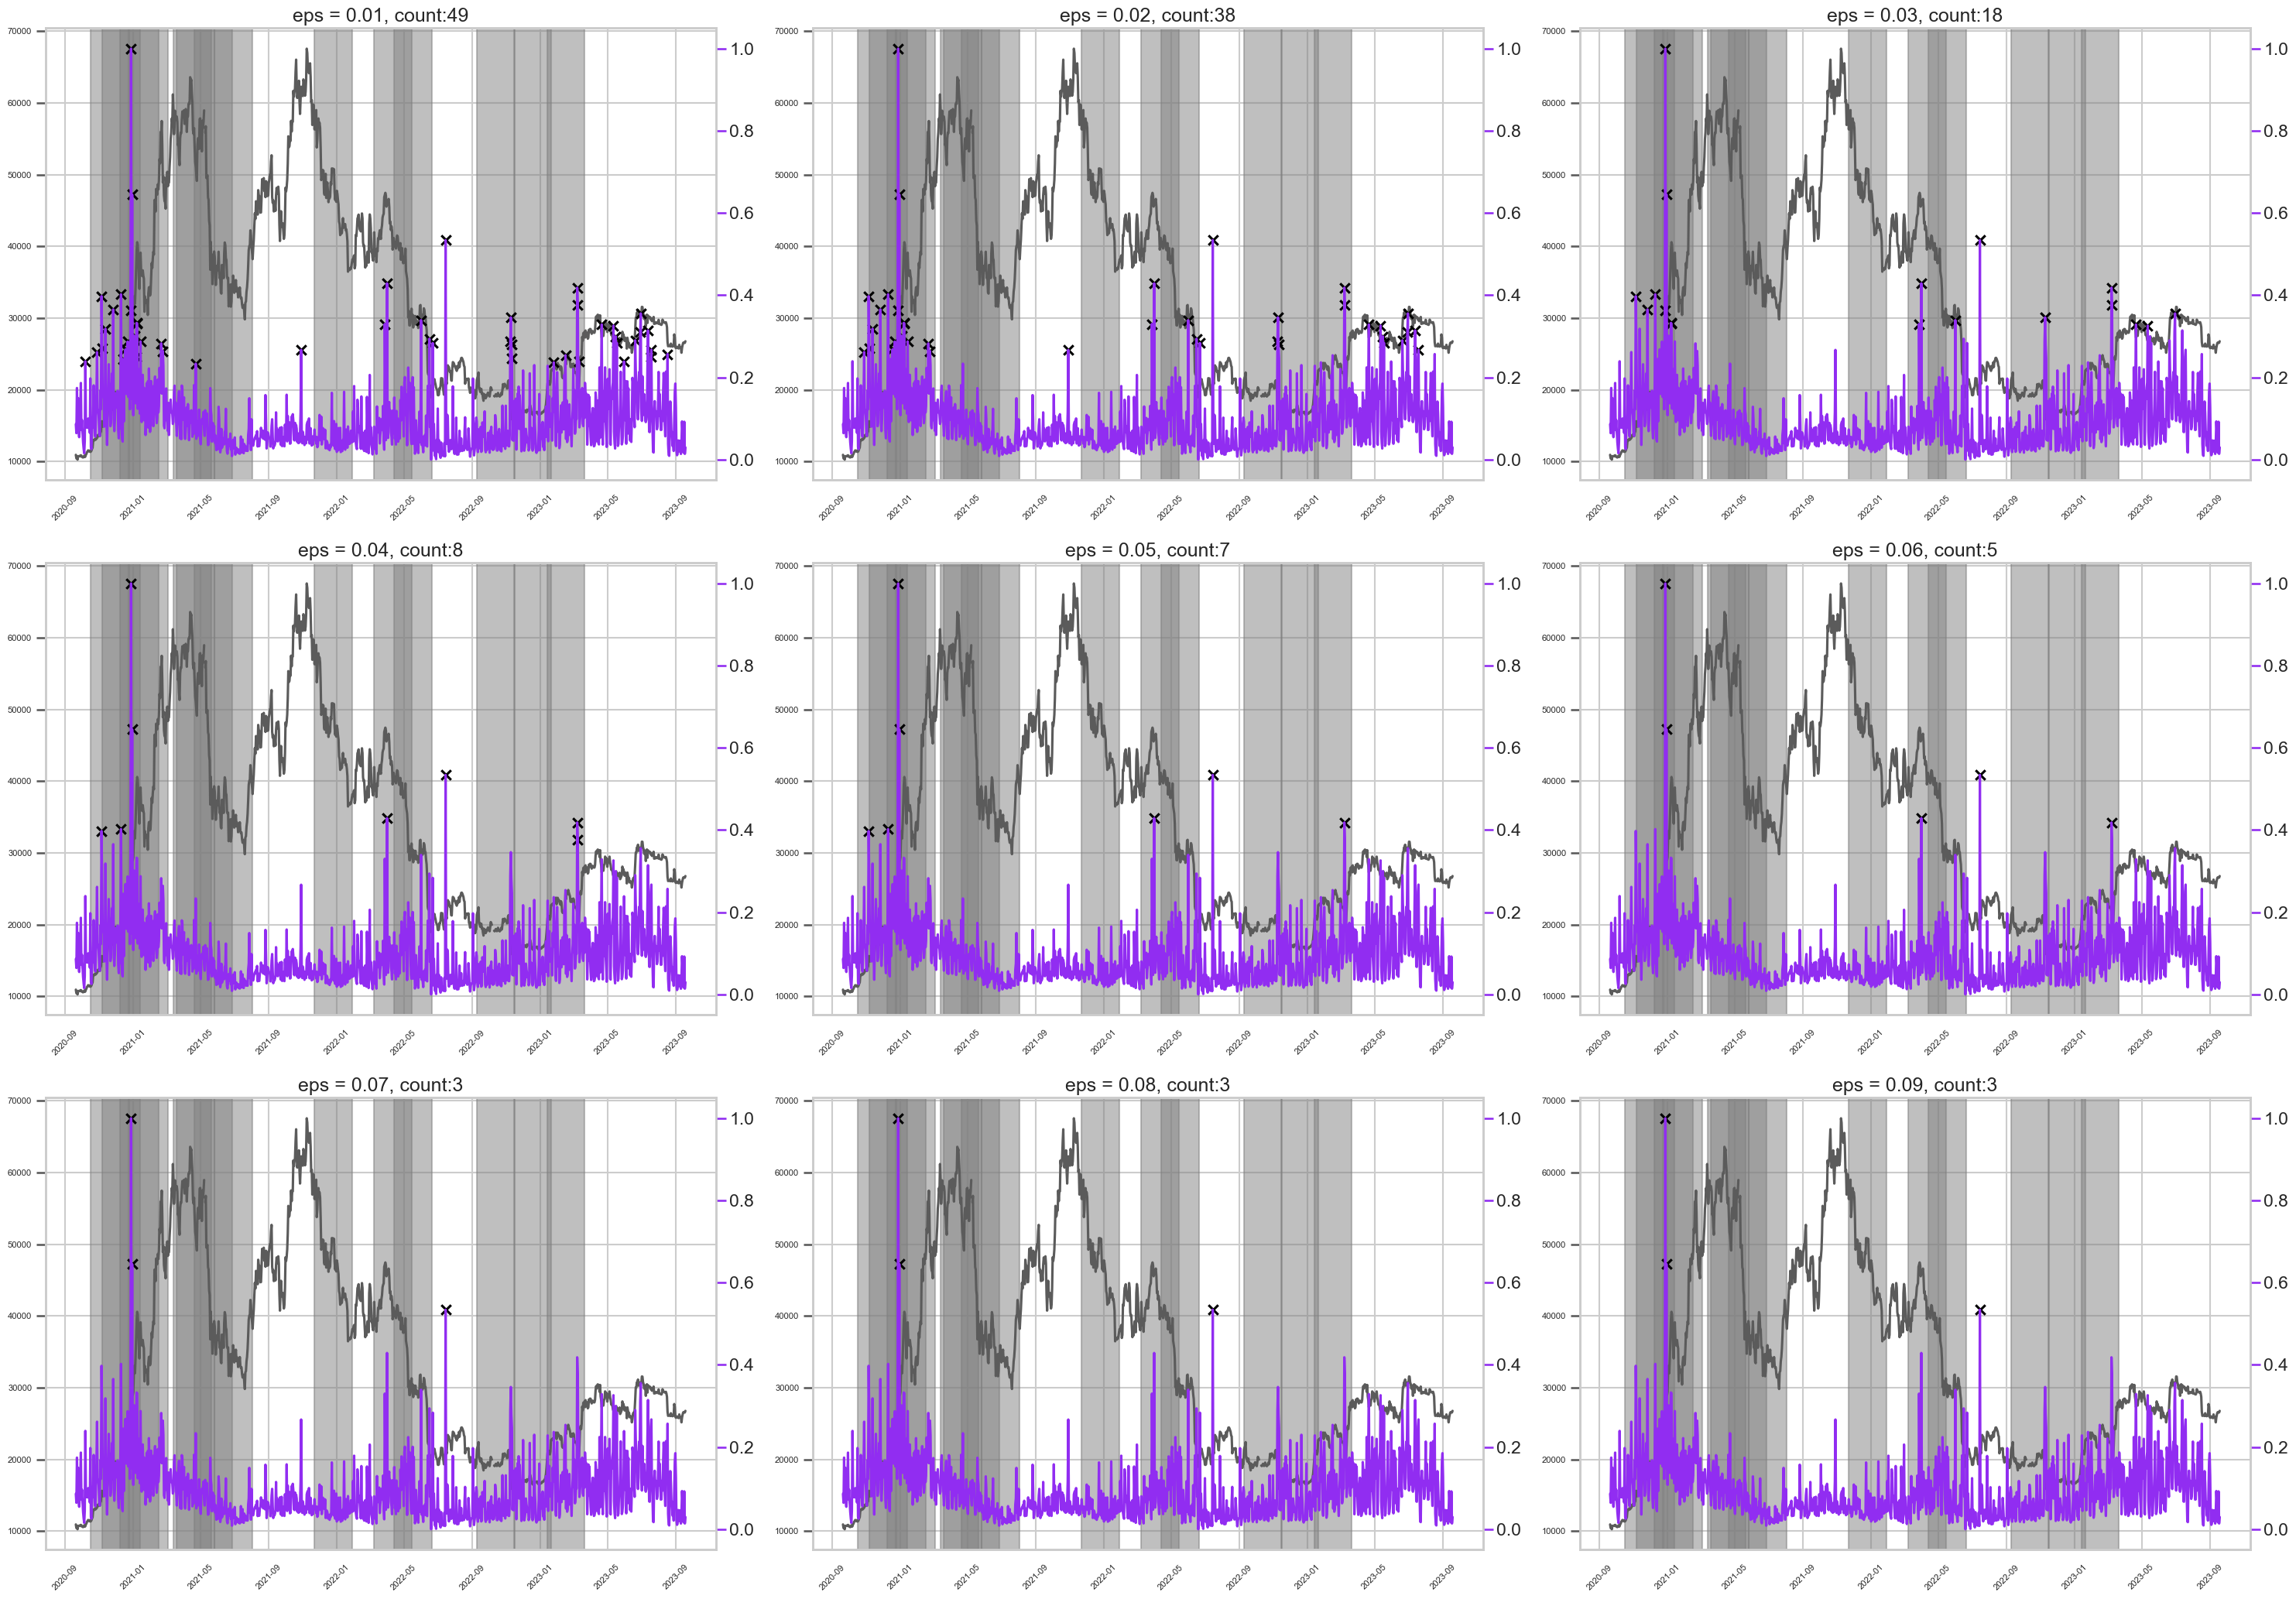

In [22]:
from datetime import datetime, timedelta
fig, axs = plt.subplots(3, 3, figsize=(30, 21))


for i in range(3):
    for j in range(3):
        ax1 = axs[i][j]

        # DBSCAN 모델 생성 및 학습
        model = DBSCAN(eps=eps[i * 3 + j], min_samples=20)
        model.fit(X)
        labels = model.labels_
        MPI_df['label'] = labels
        # 첫 번째 y축 그래프 (가격)
        ax1.plot(MPI_df['DATE'], MPI_df['PRICE'], label='price',color='#5b5b5b')
        # ax1.set_xlabel('DATE')
        # ax1.set_ylabel('PRICE',color='#5b5b5b')
        ax1.tick_params(axis='y',color='#5b5b5b')
        # ax1.legend(loc='upper left')
        ax1.tick_params(axis='x', labelrotation=45, labelsize=8)
        ax1.tick_params(axis='y', labelsize=8)
        # 두 번째 y축 그래프 (CDD)
        ax2 = ax1.twinx()
        ax2.plot(MPI_df['DATE'], MPI_df['scaled_MPI'], label='CDD',color='#912df1')
        # ax2.set_ylabel('CDD',color='#912df1')
        ax2.tick_params(axis='y',color='#912df1')

        # 이상치 표시
        label_minus_1 = MPI_df[MPI_df['label'] == -1]
        ax2.scatter(label_minus_1['DATE'], label_minus_1['scaled_MPI'], marker='x', color='black', label='CDD (-1)')

        # 구간 표시
        for index, row in df_interval.iterrows():
            start_date = row['start_date']
            end_date = row['end_date']
            ax1.axvspan(start_date, end_date, color='gray', alpha=0.5)

        # 그래프의 제목에 파라미터 값 추가
        ax1.set_title(f'eps = {eps[i * 3 + j]}, count:{len(label_minus_1)}')
        plt.grid(False)
fig.tight_layout()
plt.show()

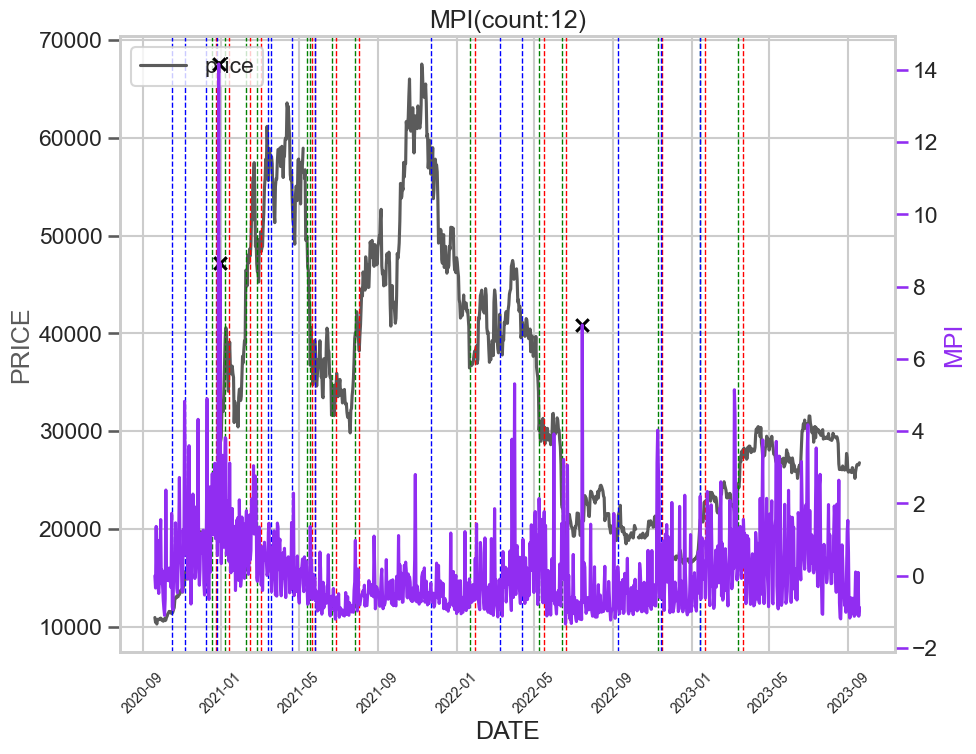

In [13]:
from datetime import datetime, timedelta


fig, ax1 = plt.subplots(figsize=(10, 8))

# 첫 번째 y축 그래프 (가격)
ax1.plot(MPI_df['DATE'], MPI_df['PRICE'], label='price',color='#5b5b5b')
ax1.set_xlabel('DATE')
ax1.set_ylabel('PRICE',color='#5b5b5b')
ax1.tick_params(axis='y',color='#5b5b5b')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', labelrotation=45, labelsize=10)
# 두 번째 y축 그래프 (CDD)
ax2 = ax1.twinx()
ax2.plot(MPI_df['DATE'], MPI_df['MPI'], label='MPI',color='#912df1')
ax2.set_ylabel('MPI',color='#912df1')
ax2.tick_params(axis='y',color='#912df1')
# ax2.legend(loc='upper right')


label_minus_1 = MPI_df[MPI_df['label'] == -1]
ax2.scatter(label_minus_1['DATE'], label_minus_1['MPI'], marker='x', color='black', label='MPI (-1)')

# 그래프 제목 설정
plt.title('MPI(count:12)')
plt.xticks(fontsize=10, rotation=45)
plt.grid(False)


for date in date_list:
    target_date = pd.to_datetime(date)  # 날짜 문자열을 datetime으로 변환
    ax1.axvline(x=target_date, color='green', linestyle='--', linewidth=1)
    
    # '일자로부터 두 달 전'을 계산하여 세로선 그리기
    two_months_ago = target_date - pd.DateOffset(months=2)
    ax1.axvline(x=two_months_ago, color='blue', linestyle='--', linewidth=1)
    
    # '일자로부터 일주일 후'를 계산하여 세로선 그리기
    one_week_later = target_date + timedelta(weeks=1)
    ax1.axvline(x=one_week_later, color='red', linestyle='--', linewidth=1)
# 그래프 표시
plt.show()

In [38]:
MPI_df[MPI_df['label'] == -1]

,DATE,PRICE,MPI,label
46,2020-11-05,15596.528035,4.822813,-1
67,2020-11-26,17191.383627,4.324108,-1
81,2020-12-10,18261.478832,4.894926,-1
98,2020-12-27,26252.732662,4.300821,-1
99,2020-12-28,27041.399430,14.157197,-1
101,2020-12-30,28879.935254,8.652573,-1
558,2022-04-01,46299.677022,5.307595,-1
663,2022-07-15,20824.937438,6.936608,-1
780,2022-11-09,15877.681327,4.025213,-1
899,2023-03-08,21704.108584,5.142889,-1
